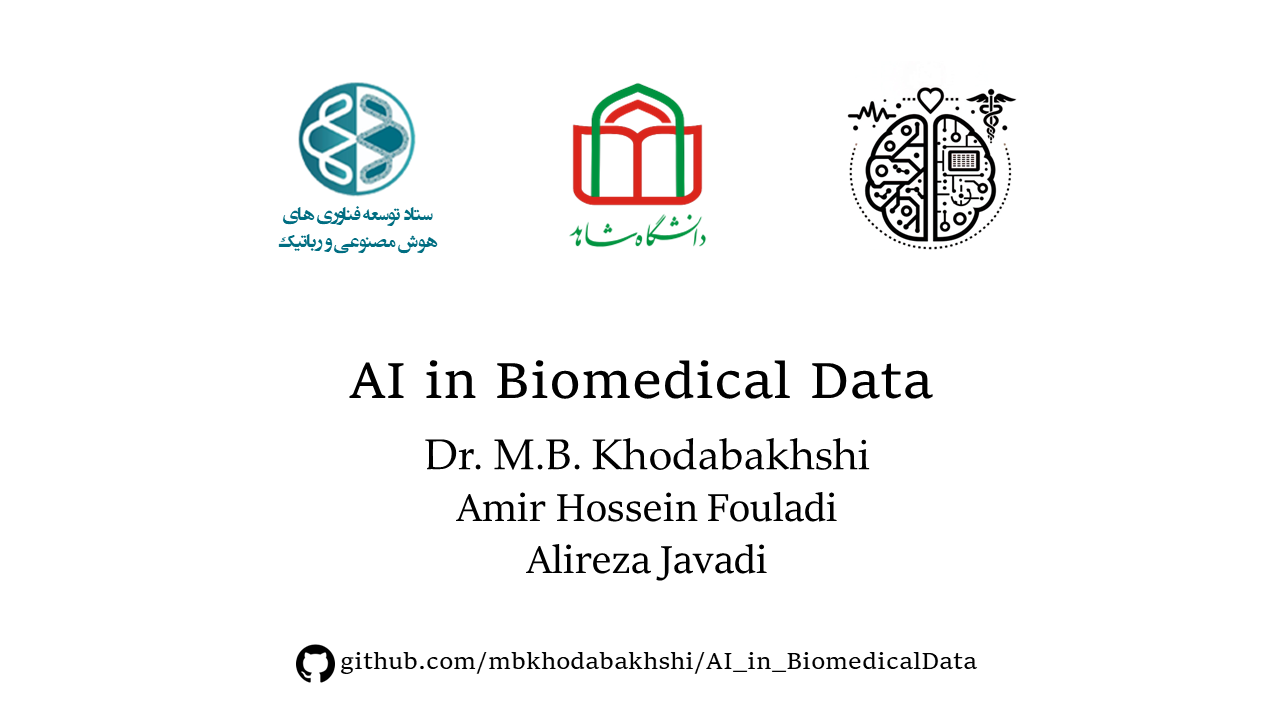

# Ensemble Learning

In this notebook, we will explore ensemble learning methods — Random Patches, Boosting, and Stacking — using the Alzheimer's Disease Neuroimaging Initiative (ADNI) data. Our objective is to classify subjects into two classes: Alzheimer's Disease (AD) and Cognitively Normal (CN).


## ADNI Dataset

The ADNI study actively supports the investigation and development of treatments that slow or stop the progression of Alzheimer’s disease (AD).

[**Access Dataset**](https://adni.loni.usc.edu/data-samples/adni-data/#AccessData)

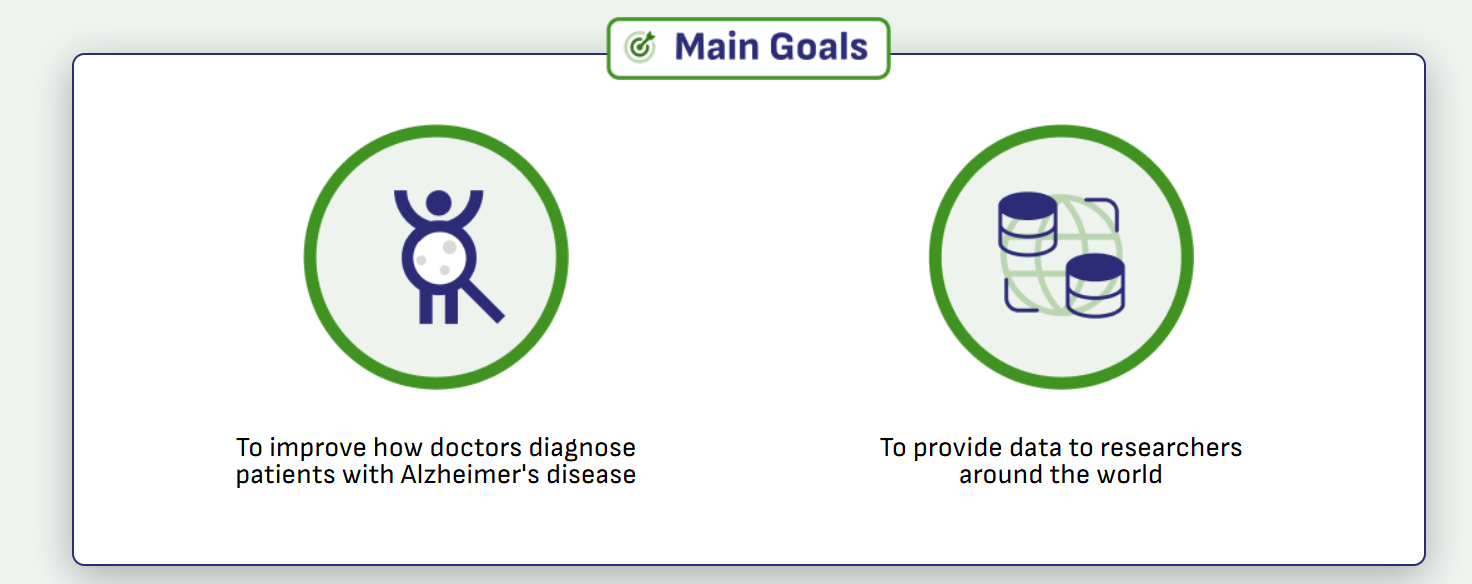

### Downolad Dataset

After accessing data, through [IDA site](https://ida.loni.usc.edu/login.jsp?project=ADNI) you can download the data.

## Needed Library

### [NiBabel Library](https://nipy.org/nibabel/)

Read and write access to common neuroimaging file formats.

### [Nilearn Library](https://nilearn.github.io/stable/index.html)
Nilearn enables approachable and versatile analyses of brain volumes. It provides statistical and machine-learning tools, with instructive documentation & open community.

### [SimpleITK](https://simpleitk.org/)
Open-source multi-dimensional image analysis in Python, R, Java, C#, Lua, Ruby, TCL and C++.

### [Pyradiomics Library](https://pyradiomics.readthedocs.io/en/latest/)
Pyradiomics provides tools to extract multiple feature classes, including First Order Statistics, Shape, GLCM (Gray Level Co-occurrence Matrix), GLSZM (Gray Level Size Zone Matrix), GLRLM (Gray Level Run Length Matrix), NGTDM (Neighboring Gray Tone Difference Matrix), and GLDM (Gray Level Dependence Matrix).

## Data Visualization


In [42]:
import nibabel as nib

brain_vol = nib.load(".\\ADNI\\AD\\I31143_orig.nii")

print(brain_vol.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 256 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : -0.70710677
quatern_d       : 0.70710677
qoffset_x       : 127.99472
qoffset_y       : -103.245575
qoffset_z       : 118.76008
srow_x         

In [43]:
brain_vol_data = brain_vol.get_fdata()
print(brain_vol_data.shape)
print(type(brain_vol_data))

(256, 256, 256)
<class 'numpy.memmap'>


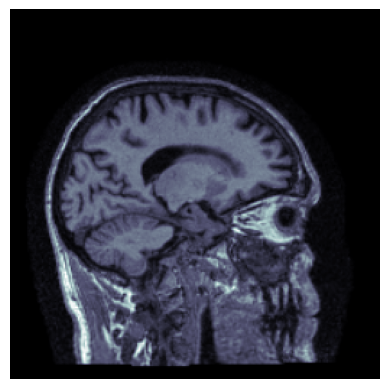

In [45]:
import matplotlib.pyplot as plt

plt.imshow(brain_vol_data[110], cmap='bone')
plt.axis('off')
plt.show()

c:\Users\SAZGAR\anaconda3\lib\site-packages\nilearn\plotting\displays\_slicers.py:1496: UserWarning: A non-diagonal affine is found in the given image. Reordering the image to get diagonal affine for finding cuts in the slices.
  cut_coords = find_cut_slices(


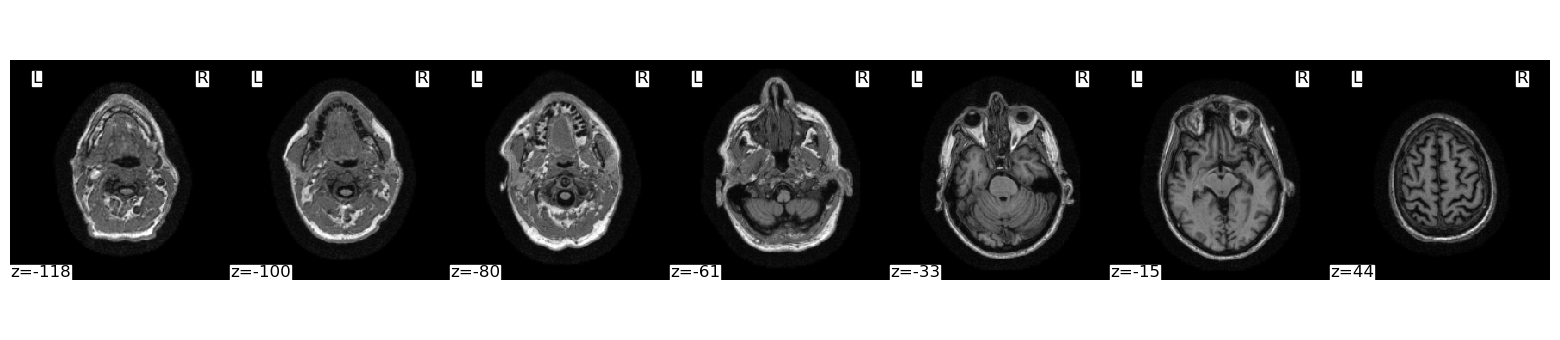

In [46]:
from nilearn import plotting

plotting.plot_img(brain_vol, cmap='gray', display_mode = 'z')
plt.show()

## Feature Extraction

To differentiate between AD and CN classes, we will use various features derived from the MRI scans, including texture features and shape features. We’ll use the `pyradiomics` library, which allows extraction of advanced radiomic features from medical imaging.

### Texture Features
- Texture features capture patterns within the MRI, useful for detecting subtle changes in brain structure that may indicate Alzheimer's.



In [ ]:
import os
import pandas as pd
import radiomics
import SimpleITK as sitk


def extract_features_from_directories(ad_dir, cn_dir, output_csv):

    all_features = pd.DataFrame()


    directories = [(ad_dir, 1), (cn_dir, 0)]

    for dir_path, label in directories:

        for filename in os.listdir(dir_path):
            if filename.endswith("_orig.nii") and not filename.endswith("_mask.nii"):

                image_path = os.path.join(dir_path, filename)
                mask_path = os.path.join(dir_path, filename.replace("_orig.nii", "_mask.nii"))

                
                sitk_image = sitk.ReadImage(image_path)
                sitk_mask = sitk.ReadImage(mask_path)

                
                ff = radiomics.firstorder.RadiomicsFirstOrder(sitk_image, sitk_mask)
                sf = radiomics.shape.RadiomicsShape(sitk_image, sitk_mask)
                glcm = radiomics.glcm.RadiomicsGLCM(sitk_image, sitk_mask)
                glszm = radiomics.glszm.RadiomicsGLSZM(sitk_image, sitk_mask)
                glrlm = radiomics.glrlm.RadiomicsGLRLM(sitk_image, sitk_mask)
                ngtdm = radiomics.ngtdm.RadiomicsNGTDM(sitk_image, sitk_mask)
                gldm = radiomics.gldm.RadiomicsGLDM(sitk_image, sitk_mask)


                first_features = ff.execute()
                shape_features = sf.execute()
                glcm_features = glcm.execute()
                glszm_features = glszm.execute()
                glrlm_features = glrlm.execute()
                ngtdm_features = ngtdm.execute()
                gldm_features = gldm.execute()

                features = {}
                features.update(first_features)
                features.update(shape_features)
                features.update(glcm_features)
                features.update(glszm_features)
                features.update(glrlm_features)
                features.update(ngtdm_features)
                features.update(gldm_features)

                
                image_features = pd.DataFrame(features, index=[0])
                image_features.insert(0, "ImageName", filename)  
                image_features["Label"] = label


                all_features = pd.concat([all_features, image_features], ignore_index=True)

    
    all_features.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")


ad_directory = r".\ADNI\AD"
cn_directory = r".\ADNI\CN"

output_csv_file = "all_radiomic_features.csv"

extract_features_from_directories(ad_directory, cn_directory, output_csv_file)


## Feature Scaling

Feature scaling is a crucial preprocessing step, especially when using models sensitive to feature magnitude differences. Scaling standardizes the dataset, ensuring all features contribute equally to the model’s performance. This is particularly important for boosting methods and SVM, which perform better when features are on a similar scale.

In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

data = pd.read_csv(".\\Features.csv")


X = data.drop(columns=["ImageName", "Label"]) 
y = data["Label"]

X.describe()

,10Percentile,90Percentile,Energy,Entropy,InterquartileRange,Kurtosis,Maximum,MeanAbsoluteDeviation,Mean,Median,...,DependenceNonUniformityNormalized,DependenceVariance,HighGrayLevelEmphasis,LargeDependenceEmphasis,LargeDependenceHighGrayLevelEmphasis,LargeDependenceLowGrayLevelEmphasis,LowGrayLevelEmphasis,SmallDependenceEmphasis,SmallDependenceHighGrayLevelEmphasis,SmallDependenceLowGrayLevelEmphasis
count,266.000000,266.000000,2.660000e+02,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,...,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000
mean,31.349624,112.796992,1.114489e+10,2.182823,46.278195,2.254479,161.808271,24.739620,78.143929,83.477444,...,0.055183,37.436087,14.949602,344.294879,5791.227231,48.848837,0.156255,0.006741,0.086344,0.001552
std,6.466309,14.895490,3.484553e+09,0.198510,7.991366,0.190180,37.723684,3.845904,10.042391,10.404710,...,0.009415,2.663526,3.288935,41.331912,1000.873155,16.807167,0.035462,0.001296,0.032236,0.000196
min,13.000000,68.000000,4.511035e+09,1.468958,23.000000,1.806394,94.000000,13.368823,49.406088,52.000000,...,0.045276,31.172006,6.655096,271.166208,3296.864245,19.393370,0.077426,0.003841,0.022790,0.000933
25%,27.000000,104.000000,8.659761e+09,2.092917,40.000000,2.111319,135.250000,22.067627,72.965021,78.000000,...,0.048864,35.514429,13.236478,316.312713,5132.766554,37.260803,0.134356,0.005831,0.063250,0.001406
50%,31.000000,113.000000,1.055241e+10,2.185232,46.500000,2.242229,153.000000,25.072223,77.962490,83.000000,...,0.052497,37.186784,14.699639,343.709357,5759.334584,45.602027,0.153320,0.006690,0.078370,0.001551
75%,35.000000,122.000000,1.272049e+10,2.320542,51.000000,2.409637,180.000000,27.302484,84.036424,89.750000,...,0.057651,39.348743,16.421852,367.341923,6271.431312,57.883847,0.177335,0.007789,0.113585,0.001703
max,51.000000,150.000000,2.345746e+10,2.677473,66.000000,2.760335,255.000000,34.877006,103.533379,111.000000,...,0.107315,44.869365,24.348846,473.932159,8995.663419,120.629184,0.296226,0.010028,0.181360,0.001925


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pd.DataFrame(X_train_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
count,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,...,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02
mean,-2.723189e-16,-1.235909e-16,2.639398e-16,2.136656e-16,2.094760e-16,1.462143e-15,3.351617e-16,-5.949120e-16,3.184036e-16,4.713211e-16,...,-5.027425e-16,-2.660346e-16,1.916706e-16,5.488272e-16,-4.482787e-16,-2.786031e-16,9.175051e-16,4.493261e-16,-2.429922e-16,2.429922e-16
std,1.002367e+00,1.002367e+00,1.002367e+00,1.002367e+00,1.002367e+00,1.002367e+00,1.002367e+00,1.002367e+00,1.002367e+00,1.002367e+00,...,1.002367e+00,1.002367e+00,1.002367e+00,1.002367e+00,1.002367e+00,1.002367e+00,1.002367e+00,1.002367e+00,1.002367e+00,1.002367e+00
min,-2.110045e+00,-2.994638e+00,-1.938490e+00,-3.479020e+00,-2.848516e+00,-2.287872e+00,-1.790590e+00,-2.888568e+00,-2.873926e+00,-3.023382e+00,...,-1.041590e+00,-2.386069e+00,-2.521025e+00,-1.741775e+00,-2.486500e+00,-1.824511e+00,-2.327621e+00,-2.219363e+00,-1.951779e+00,-2.833394e+00
25%,-6.555777e-01,-5.890884e-01,-6.879466e-01,-4.317109e-01,-7.745662e-01,-7.541094e-01,-7.209787e-01,-6.700817e-01,-5.142650e-01,-5.275945e-01,...,-6.852075e-01,-6.994327e-01,-5.068502e-01,-6.738473e-01,-6.964869e-01,-7.052042e-01,-6.632641e-01,-6.728281e-01,-6.990082e-01,-7.232210e-01
50%,-1.707551e-01,3.332666e-02,-1.361562e-01,3.746293e-02,7.941318e-02,-1.500087e-01,-2.129132e-01,9.456154e-02,1.018774e-02,-1.874469e-02,...,-2.808998e-01,-9.878724e-02,-4.055316e-02,-2.160191e-02,-2.524788e-02,-1.750645e-01,-1.047998e-01,-4.538927e-02,-2.458152e-01,-2.766344e-02
75%,5.160769e-01,6.389197e-01,4.704720e-01,6.945663e-01,6.893985e-01,7.785656e-01,4.823342e-01,6.573758e-01,5.301009e-01,5.627980e-01,...,2.764767e-01,7.359742e-01,4.648279e-01,5.246090e-01,5.062719e-01,5.273687e-01,5.947532e-01,7.802642e-01,8.598400e-01,7.226521e-01
max,3.223003e+00,2.522987e+00,3.611478e+00,2.442690e+00,2.397357e+00,2.663790e+00,2.514596e+00,2.575804e+00,2.592774e+00,2.695121e+00,...,5.236993e+00,2.738460e+00,2.916559e+00,3.039730e+00,3.244440e+00,4.004143e+00,3.542729e+00,2.509532e+00,2.949926e+00,1.934862e+00


## Individual Model Training

Before diving into ensemble methods, let's evaluate each model individually. We will train:
1. **Support Vector Machine (SVM)**
2. **Logistic Regression** 
3. **Decision Tree** 

We’ll then use these models in ensemble methods to compare their individual performance with combined performance.


In [26]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

without_dimension_reduction = []

svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)


y_pred_svm = svm_model.predict(X_test_scaled)


print("Support Vector Machine (SVM) Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

without_dimension_reduction.append(accuracy_score(y_test, y_pred_svm))


Support Vector Machine (SVM) Model Performance
Accuracy: 0.6296296296296297
              precision    recall  f1-score   support

           0       0.59      0.68      0.63        25
           1       0.68      0.59      0.63        29

    accuracy                           0.63        54
   macro avg       0.63      0.63      0.63        54
weighted avg       0.64      0.63      0.63        54



In [27]:
from sklearn.linear_model import LogisticRegression


log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train_scaled, y_train)


y_pred_log_reg = log_reg_model.predict(X_test_scaled)


print("Logistic Regression Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print(classification_report(y_test, y_pred_log_reg))

without_dimension_reduction.append(accuracy_score(y_test, y_pred_log_reg))

Logistic Regression Model Performance
Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        25
           1       0.72      0.62      0.67        29

    accuracy                           0.67        54
   macro avg       0.67      0.67      0.67        54
weighted avg       0.67      0.67      0.67        54



In [28]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)

y_pred_dt = dt_model.predict(X_test_scaled)

print("Decision Tree Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

without_dimension_reduction.append(accuracy_score(y_test, y_pred_dt))


Decision Tree Model Performance
Accuracy: 0.5740740740740741
              precision    recall  f1-score   support

           0       0.55      0.44      0.49        25
           1       0.59      0.69      0.63        29

    accuracy                           0.57        54
   macro avg       0.57      0.56      0.56        54
weighted avg       0.57      0.57      0.57        54



## Ensemble Learning Methods

Now that we’ve observed the performance of individual models, let’s apply three ensemble methods:
1. **Random Patches (Bagging)** - Uses bagging to create diverse models by sampling subsets of data.
2. **AdaBoost (Adaptive Boosting)** - Adjusts model weights to focus on misclassified instances, gradually improving the model’s accuracy.
3. **Gradient Boosting** - Builds each new model to correct errors made by previous models, optimizing performance by reducing the loss function.
4. **XGBoost** - An optimized version of Gradient Boosting that incorporates additional features such as regularization and parallel processing, making it faster and more efficient.
5. **Stacking** - Combines predictions from multiple models using a meta-classifier to enhance performance.


In [29]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(n_estimators=10, max_samples = 0.5, max_features = 0.5,random_state=42)
bagging.fit(X_train_scaled, y_train)


y_pred_bagging = bagging.predict(X_test_scaled)
print("Random Patches Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_bagging))
print(classification_report(y_test, y_pred_bagging))

without_dimension_reduction.append(accuracy_score(y_test, y_pred_bagging))

Random Patches Performance
Accuracy: 0.5740740740740741
              precision    recall  f1-score   support

           0       0.54      0.56      0.55        25
           1       0.61      0.59      0.60        29

    accuracy                           0.57        54
   macro avg       0.57      0.57      0.57        54
weighted avg       0.58      0.57      0.57        54



In [30]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_model = AdaBoostClassifier(n_estimators=50, random_state=42)
adaboost_model.fit(X_train_scaled, y_train)


y_pred_adaboost = adaboost_model.predict(X_test_scaled)
print("AdaBoost Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_adaboost))
print(classification_report(y_test, y_pred_adaboost))

without_dimension_reduction.append(accuracy_score(y_test, y_pred_adaboost))

AdaBoost Model Performance
Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        25
           1       0.69      0.69      0.69        29

    accuracy                           0.67        54
   macro avg       0.66      0.66      0.66        54
weighted avg       0.67      0.67      0.67        54



In [31]:
from sklearn.ensemble import GradientBoostingClassifier


gradient_boosting_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gradient_boosting_model.fit(X_train_scaled, y_train)


y_pred_gradient_boosting = gradient_boosting_model.predict(X_test_scaled)
print("Gradient Boosting Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_gradient_boosting))
print(classification_report(y_test, y_pred_gradient_boosting))

without_dimension_reduction.append(accuracy_score(y_test, y_pred_gradient_boosting))

Gradient Boosting Model Performance
Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        25
           1       0.72      0.62      0.67        29

    accuracy                           0.67        54
   macro avg       0.67      0.67      0.67        54
weighted avg       0.67      0.67      0.67        54



In [32]:
from xgboost import XGBClassifier


xgboost_model = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
xgboost_model.fit(X_train_scaled, y_train)


y_pred_xgboost = xgboost_model.predict(X_test_scaled)
print("XGBoost Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_xgboost))
print(classification_report(y_test, y_pred_xgboost))

without_dimension_reduction.append(accuracy_score(y_test, y_pred_xgboost))

XGBoost Model Performance
Accuracy: 0.6296296296296297
              precision    recall  f1-score   support

           0       0.59      0.64      0.62        25
           1       0.67      0.62      0.64        29

    accuracy                           0.63        54
   macro avg       0.63      0.63      0.63        54
weighted avg       0.63      0.63      0.63        54



In [33]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier


base_learners = [
    ('svm', SVC(kernel='linear', probability=True)),
    ('log_reg', LogisticRegression()),
    ('dt', DecisionTreeClassifier()),
]

meta_model = RandomForestClassifier()


stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model)


stacking_model.fit(X_train_scaled, y_train)


y_pred_stacking = stacking_model.predict(X_test_scaled)

print("Stacking Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_stacking))
print(classification_report(y_test, y_pred_stacking))

without_dimension_reduction.append(accuracy_score(y_test, y_pred_stacking))


Stacking Model Performance
Accuracy: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.52      0.68      0.59        25
           1       0.62      0.45      0.52        29

    accuracy                           0.56        54
   macro avg       0.57      0.56      0.55        54
weighted avg       0.57      0.56      0.55        54



## Dimensionality Reduction Techniques: PCA, LDA, and t-SNE

Dimensionality reduction is essential when working with high-dimensional datasets. Reducing the number of features can speed up training, reduce overfitting, and enhance model interpretability. In this notebook, we will explore three popular techniques:

1. **PCA (Principal Component Analysis)**: A linear technique that reduces the dimensionality by projecting data onto a smaller number of uncorrelated variables (principal components), preserving as much variance as possible.
   
2. **LDA (Linear Discriminant Analysis)**: A supervised technique that reduces the dimensionality by finding the linear combination of features that best separate the classes in the dataset.

3. **t-SNE (t-Distributed Stochastic Neighbor Embedding)**: A non-linear technique mainly used for visualization. t-SNE reduces the dimensions to 2 or 3 while preserving the local structure of the data.

### Why Use Dimensionality Reduction?
- **PCA** and **LDA** are particularly useful for improving model performance by reducing noise and avoiding the curse of dimensionality.
- **t-SNE** is excellent for visualizing high-dimensional data and discovering patterns or clusters.


In [34]:
from sklearn.decomposition import PCA

pca_acc = []

pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


svm_model.fit(X_train_pca, y_train)
y_pred_svm_pca = svm_model.predict(X_test_pca)
print("SVM Model Performance (PCA-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_svm_pca))
print(classification_report(y_test, y_pred_svm_pca))

pca_acc.append(accuracy_score(y_test, y_pred_svm_pca))

# Repeat for other models (Logistic Regression, Decision Tree, AdaBoost, Gradient Boosting, XGBoost, Stacking)
# Logistic Regression
log_reg_model.fit(X_train_pca, y_train)
y_pred_logreg_pca = log_reg_model.predict(X_test_pca)
print("Logistic Regression Model Performance (PCA-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg_pca))
print(classification_report(y_test, y_pred_logreg_pca))

pca_acc.append(accuracy_score(y_test, y_pred_logreg_pca))

# Decision Tree
dt_model.fit(X_train_pca, y_train)
y_pred_dt_pca = dt_model.predict(X_test_pca)
print("Decision Tree Model Performance (PCA-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_dt_pca))
print(classification_report(y_test, y_pred_dt_pca))

pca_acc.append(accuracy_score(y_test, y_pred_dt_pca))

# Random Patches
bagging.fit(X_train_pca, y_train)
y_pred_bagging_pca = bagging.predict(X_test_pca)
print("Random Patches Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_bagging_pca))
print(classification_report(y_test, y_pred_bagging))

pca_acc.append(accuracy_score(y_test, y_pred_bagging_pca))

# AdaBoost
adaboost_model.fit(X_train_pca, y_train)
y_pred_adaboost_pca = adaboost_model.predict(X_test_pca)
print("AdaBoost Model Performance (PCA-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_adaboost_pca))
print(classification_report(y_test, y_pred_adaboost_pca))

pca_acc.append(accuracy_score(y_test, y_pred_adaboost_pca))

# Gradient Boosting
gradient_boosting_model.fit(X_train_pca, y_train)
y_pred_gradient_boosting_pca = gradient_boosting_model.predict(X_test_pca)
print("Gradient Boosting Model Performance (PCA-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_gradient_boosting_pca))
print(classification_report(y_test, y_pred_gradient_boosting_pca))

pca_acc.append(accuracy_score(y_test, y_pred_gradient_boosting_pca))

# XGBoost
xgboost_model.fit(X_train_pca, y_train)
y_pred_xgboost_pca = xgboost_model.predict(X_test_pca)
print("XGBoost Model Performance (PCA-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_xgboost_pca))
print(classification_report(y_test, y_pred_xgboost_pca))

pca_acc.append(accuracy_score(y_test, y_pred_xgboost_pca))

# Stacking
stacking_model.fit(X_train_pca, y_train)
y_pred_stacking_pca = stacking_model.predict(X_test_pca)
print("Stacking Model Performance (PCA-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_stacking_pca))
print(classification_report(y_test, y_pred_stacking_pca))

pca_acc.append(accuracy_score(y_test, y_pred_stacking_pca))

SVM Model Performance (PCA-reduced Data)
Accuracy: 0.6111111111111112
              precision    recall  f1-score   support

           0       0.57      0.68      0.62        25
           1       0.67      0.55      0.60        29

    accuracy                           0.61        54
   macro avg       0.62      0.62      0.61        54
weighted avg       0.62      0.61      0.61        54

Logistic Regression Model Performance (PCA-reduced Data)
Accuracy: 0.5925925925925926
              precision    recall  f1-score   support

           0       0.55      0.64      0.59        25
           1       0.64      0.55      0.59        29

    accuracy                           0.59        54
   macro avg       0.60      0.60      0.59        54
weighted avg       0.60      0.59      0.59        54

Decision Tree Model Performance (PCA-reduced Data)
Accuracy: 0.5925925925925926
              precision    recall  f1-score   support

           0       0.57      0.52      0.54        25
 

## LDA (Linear Discriminant Analysis)

LDA requires class labels for dimensionality reduction, and the number of components is limited to `min(n_classes - 1, n_features)`.


In [47]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_acc = []

lda = LinearDiscriminantAnalysis(n_components=1)  
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)


svm_model.fit(X_train_lda, y_train)
y_pred_svm_lda = svm_model.predict(X_test_lda)
print("SVM Model Performance (LDA-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_svm_lda))
print(classification_report(y_test, y_pred_svm_lda))

lda_acc.append(accuracy_score(y_test, y_pred_svm_lda))

# Repeat for other models (Logistic Regression, Decision Tree, AdaBoost, Gradient Boosting, XGBoost, Stacking)
# Logistic Regression
log_reg_model.fit(X_train_lda, y_train)
y_pred_logreg_lda = log_reg_model.predict(X_test_lda)
print("Logistic Regression Model Performance (LDA-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg_lda))
print(classification_report(y_test, y_pred_logreg_lda))

lda_acc.append(accuracy_score(y_test, y_pred_logreg_lda))

# Decision Tree
dt_model.fit(X_train_lda, y_train)
y_pred_dt_lda = dt_model.predict(X_test_lda)
print("Decision Tree Model Performance (LDA-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_dt_lda))
print(classification_report(y_test, y_pred_dt_lda))

lda_acc.append(accuracy_score(y_test, y_pred_dt_lda))

# Random Patches
bagging.fit(X_train_lda, y_train)
y_pred_bagging_lda = bagging.predict(X_test_lda)
print("Random Patches Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_bagging_lda))
print(classification_report(y_test, y_pred_bagging_lda))

lda_acc.append(accuracy_score(y_test, y_pred_bagging_lda))

# AdaBoost
adaboost_model.fit(X_train_lda, y_train)
y_pred_adaboost_lda = adaboost_model.predict(X_test_lda)
print("AdaBoost Model Performance (LDA-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_adaboost_lda))
print(classification_report(y_test, y_pred_adaboost_lda))

lda_acc.append(accuracy_score(y_test, y_pred_adaboost_lda))

# Gradient Boosting
gradient_boosting_model.fit(X_train_lda, y_train)
y_pred_gradient_boosting_lda = gradient_boosting_model.predict(X_test_lda)
print("Gradient Boosting Model Performance (LDA-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_gradient_boosting_lda))
print(classification_report(y_test, y_pred_gradient_boosting_lda))

lda_acc.append(accuracy_score(y_test, y_pred_gradient_boosting_lda))

# XGBoost
xgboost_model.fit(X_train_lda, y_train)
y_pred_xgboost_lda = xgboost_model.predict(X_test_lda)
print("XGBoost Model Performance (LDA-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_xgboost_lda))
print(classification_report(y_test, y_pred_xgboost_lda))

lda_acc.append(accuracy_score(y_test, y_pred_xgboost_lda))

# Stacking
stacking_model.fit(X_train_lda, y_train)
y_pred_stacking_lda = stacking_model.predict(X_test_lda)
print("Stacking Model Performance (LDA-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_stacking_lda))
print(classification_report(y_test, y_pred_stacking_lda))

lda_acc.append(accuracy_score(y_test, y_pred_stacking_lda))

SVM Model Performance (LDA-reduced Data)
Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.67      0.56      0.61        25
           1       0.67      0.76      0.71        29

    accuracy                           0.67        54
   macro avg       0.67      0.66      0.66        54
weighted avg       0.67      0.67      0.66        54

Logistic Regression Model Performance (LDA-reduced Data)
Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.67      0.56      0.61        25
           1       0.67      0.76      0.71        29

    accuracy                           0.67        54
   macro avg       0.67      0.66      0.66        54
weighted avg       0.67      0.67      0.66        54

Decision Tree Model Performance (LDA-reduced Data)
Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.67      0.56      0.61        25
 

## t-SNE (t-Distributed Stochastic Neighbor Embedding)


In [39]:
import numpy as np
from sklearn.manifold import TSNE

tsne_acc = []

X_combined = np.vstack((X_train_scaled, X_test_scaled))
y_combined = np.hstack((y_train, y_test))

tsne = TSNE(n_components=2, random_state=42)
X_combined_tsne = tsne.fit_transform(X_combined)

X_train_tsne = X_combined_tsne[:len(X_train_scaled)]
X_test_tsne = X_combined_tsne[len(X_train_scaled):]


svm_model.fit(X_train_tsne, y_train)
y_pred_svm_tsne = svm_model.predict(X_test_tsne)
print("SVM Model Performance (t-SNE-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_svm_tsne))
print(classification_report(y_test, y_pred_svm_tsne))

tsne_acc.append(accuracy_score(y_test, y_pred_svm_tsne))

# Repeat for other models (Logistic Regression, Decision Tree, AdaBoost, Gradient Boosting, XGBoost, Stacking)
# Logistic Regression
log_reg_model.fit(X_train_tsne, y_train)
y_pred_logreg_tsne = log_reg_model.predict(X_test_tsne)
print("Logistic Regression Model Performance (t-SNE-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg_tsne))
print(classification_report(y_test, y_pred_logreg_tsne))

tsne_acc.append(accuracy_score(y_test, y_pred_logreg_tsne))

# Decision Tree
dt_model.fit(X_train_tsne, y_train)
y_pred_dt_tsne = dt_model.predict(X_test_tsne)
print("Decision Tree Model Performance (t-SNE-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_dt_tsne))
print(classification_report(y_test, y_pred_dt_tsne))

tsne_acc.append(accuracy_score(y_test, y_pred_dt_tsne))

# Random Patches
bagging.fit(X_train_tsne, y_train)
y_pred_bagging_tsne = bagging.predict(X_test_tsne)
print("Random Patches Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_bagging_tsne))
print(classification_report(y_test, y_pred_bagging_tsne))

tsne_acc.append(accuracy_score(y_test, y_pred_bagging_tsne))


# AdaBoost
adaboost_model.fit(X_train_tsne, y_train)
y_pred_adaboost_tsne = adaboost_model.predict(X_test_tsne)
print("AdaBoost Model Performance (t-SNE-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_adaboost_tsne))
print(classification_report(y_test, y_pred_adaboost_tsne))

tsne_acc.append(accuracy_score(y_test, y_pred_adaboost_tsne))

# Gradient Boosting
gradient_boosting_model.fit(X_train_tsne, y_train)
y_pred_gradient_boosting_tsne = gradient_boosting_model.predict(X_test_tsne)
print("Gradient Boosting Model Performance (t-SNE-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_gradient_boosting_tsne))
print(classification_report(y_test, y_pred_gradient_boosting_tsne))

tsne_acc.append(accuracy_score(y_test, y_pred_gradient_boosting_tsne))

# XGBoost
xgboost_model.fit(X_train_tsne, y_train)
y_pred_xgboost_tsne = xgboost_model.predict(X_test_tsne)
print("XGBoost Model Performance (t-SNE-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_xgboost_tsne))
print(classification_report(y_test, y_pred_xgboost_tsne))

tsne_acc.append(accuracy_score(y_test, y_pred_xgboost_tsne))

# Stacking
stacking_model.fit(X_train_tsne, y_train)
y_pred_stacking_tsne = stacking_model.predict(X_test_tsne)
print("Stacking Model Performance (t-SNE-reduced Data)")
print("Accuracy:", accuracy_score(y_test, y_pred_stacking_tsne))
print(classification_report(y_test, y_pred_stacking_tsne))

tsne_acc.append(accuracy_score(y_test, y_pred_stacking_tsne))


SVM Model Performance (t-SNE-reduced Data)
Accuracy: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.52      0.64      0.57        25
           1       0.61      0.48      0.54        29

    accuracy                           0.56        54
   macro avg       0.56      0.56      0.55        54
weighted avg       0.57      0.56      0.55        54

Logistic Regression Model Performance (t-SNE-reduced Data)
Accuracy: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.52      0.68      0.59        25
           1       0.62      0.45      0.52        29

    accuracy                           0.56        54
   macro avg       0.57      0.56      0.55        54
weighted avg       0.57      0.56      0.55        54

Decision Tree Model Performance (t-SNE-reduced Data)
Accuracy: 0.6481481481481481
              precision    recall  f1-score   support

           0       0.60      0.72      0.65      

## Visualizing Model Performance

In this section, we visualize the performance of the following models: SVM, Logistic Regression, Decision Tree, AdaBoost, Gradient Boosting, and XGBoost, under four different scenarios:

1. Without dimensionality reduction
2. After applying PCA (Principal Component Analysis)
3. After applying LDA (Linear Discriminant Analysis)
4. After applying t-SNE (t-Distributed Stochastic Neighbor Embedding)



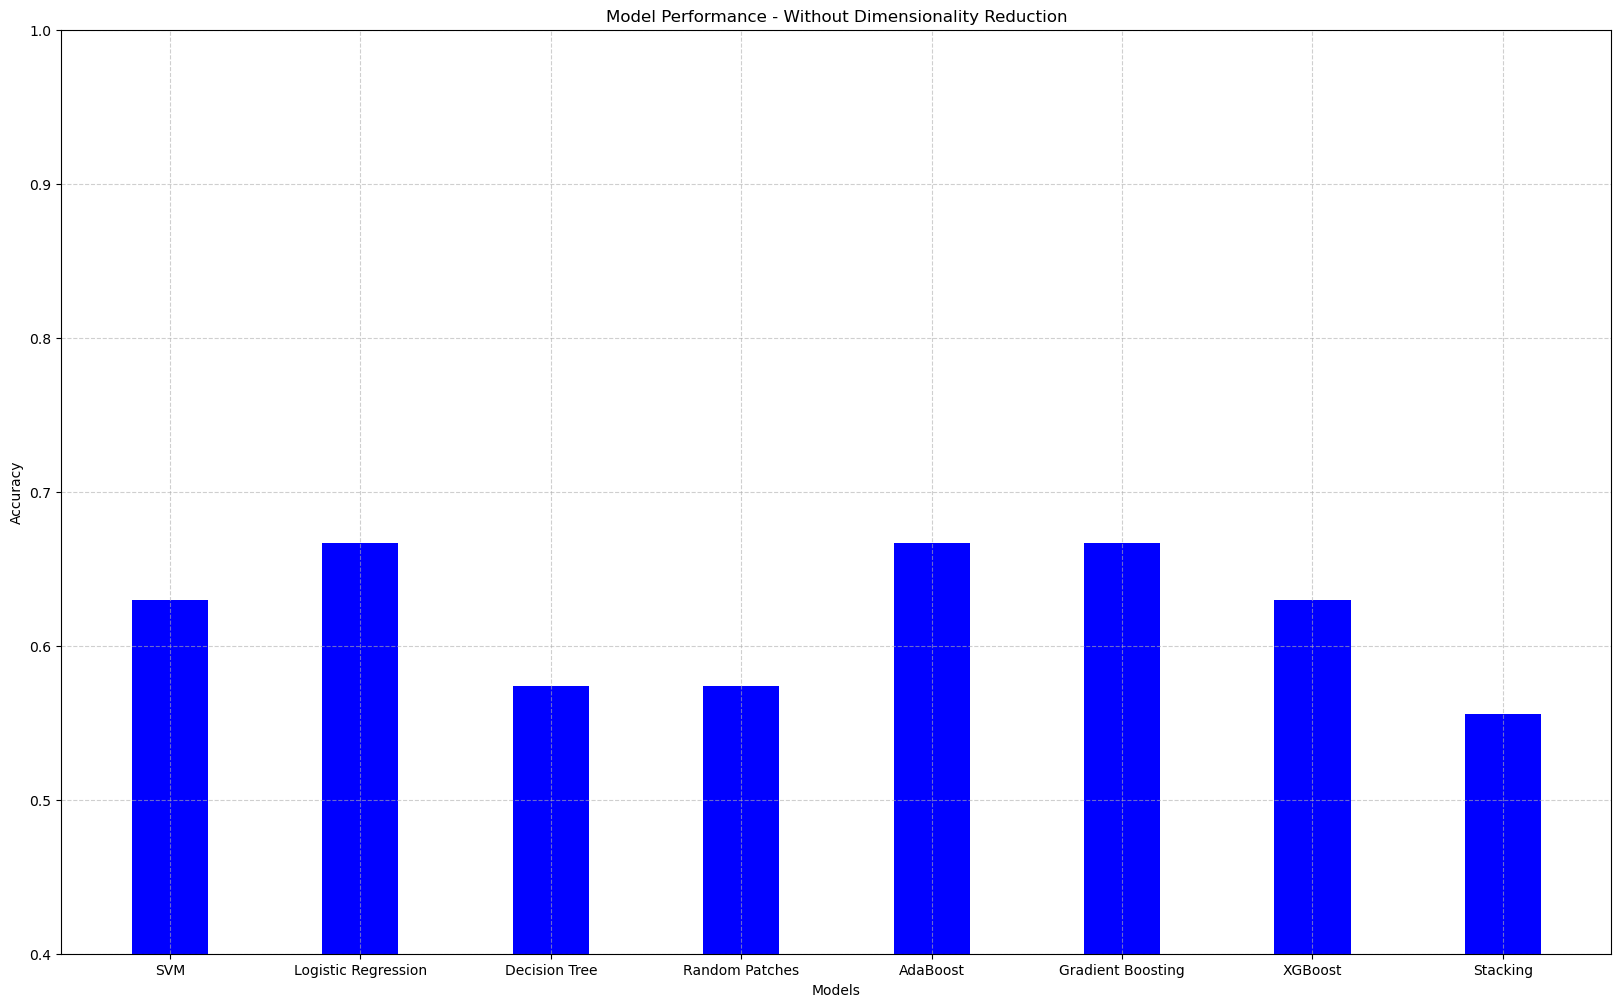

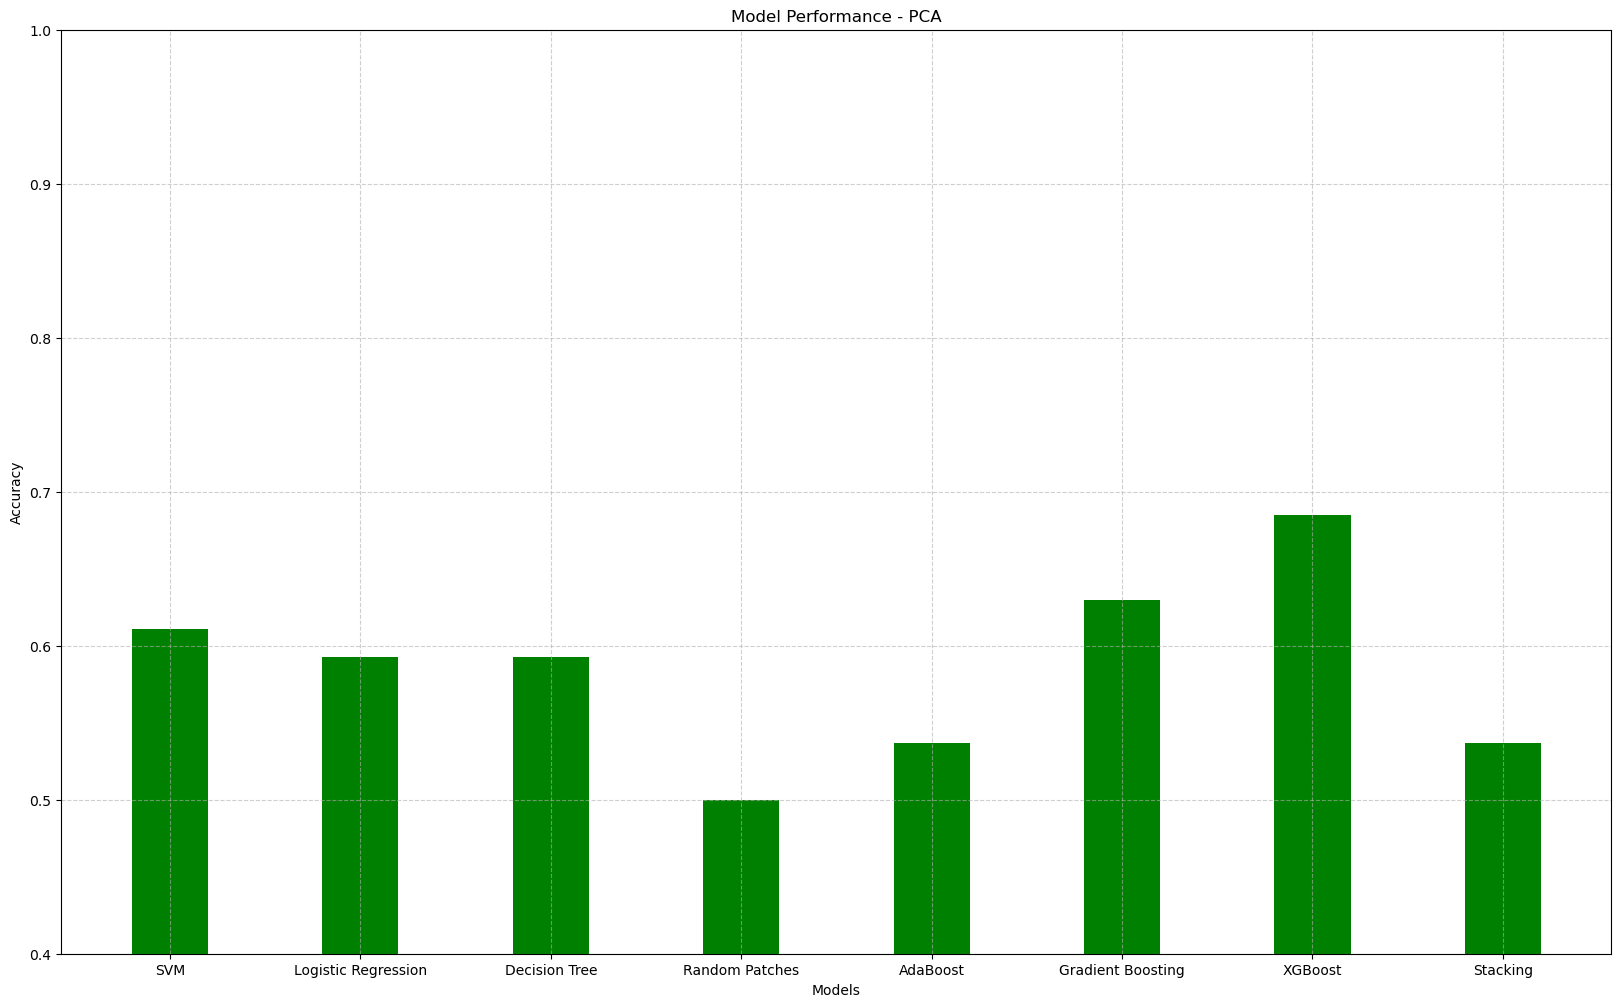

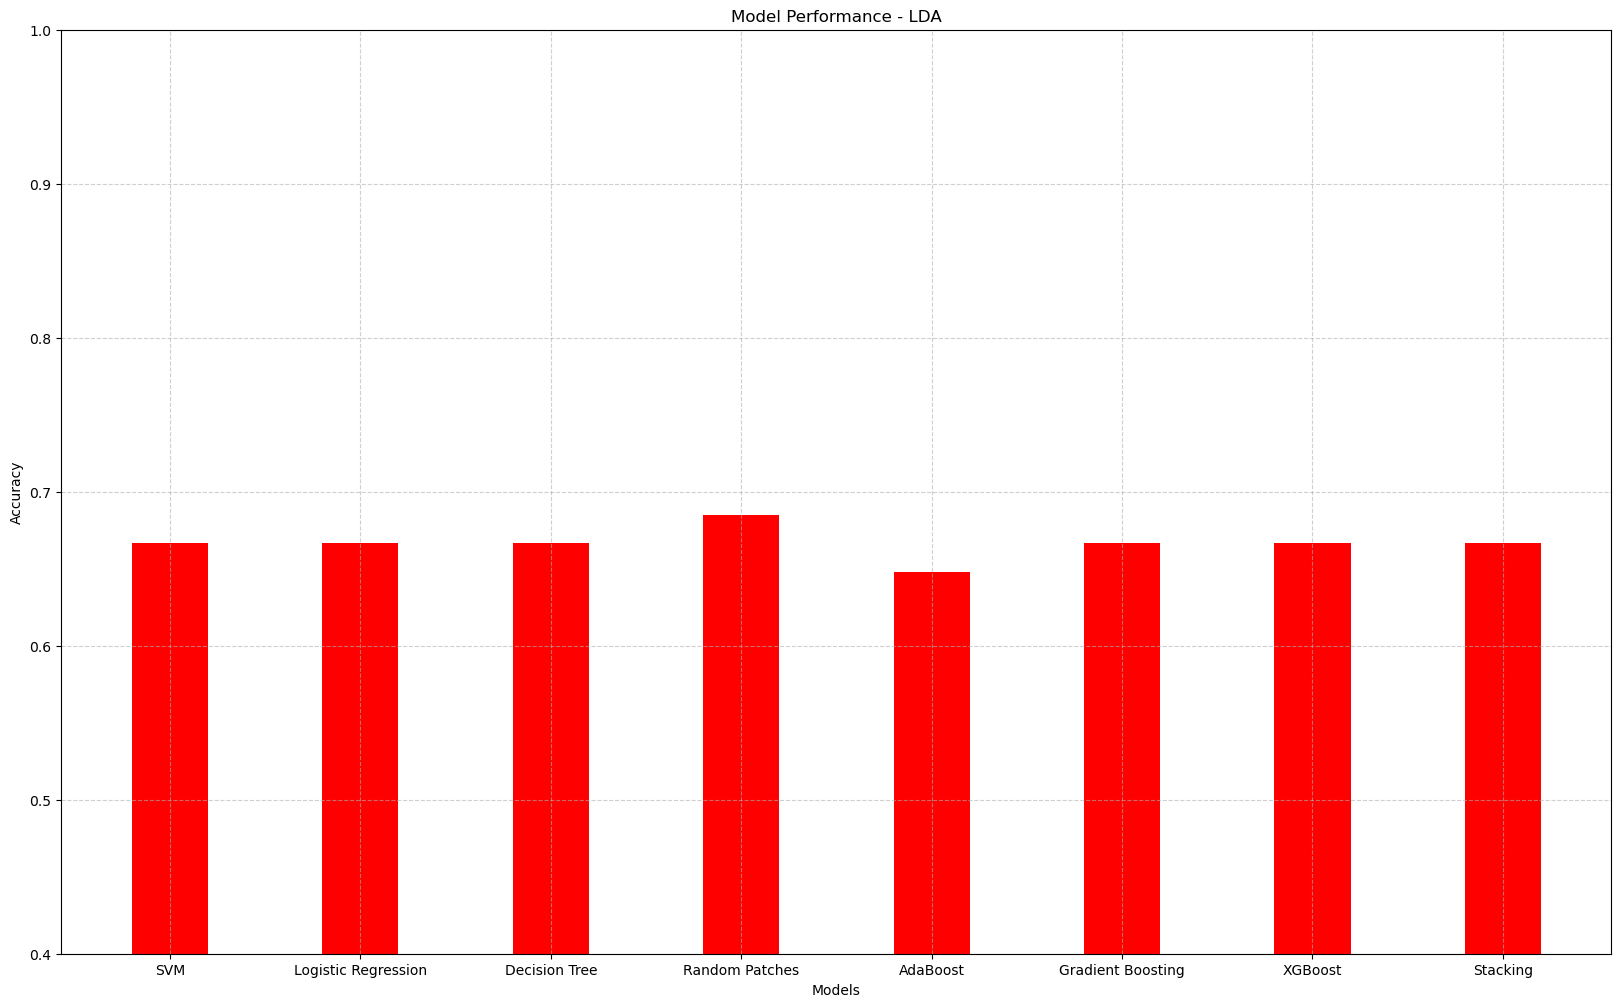

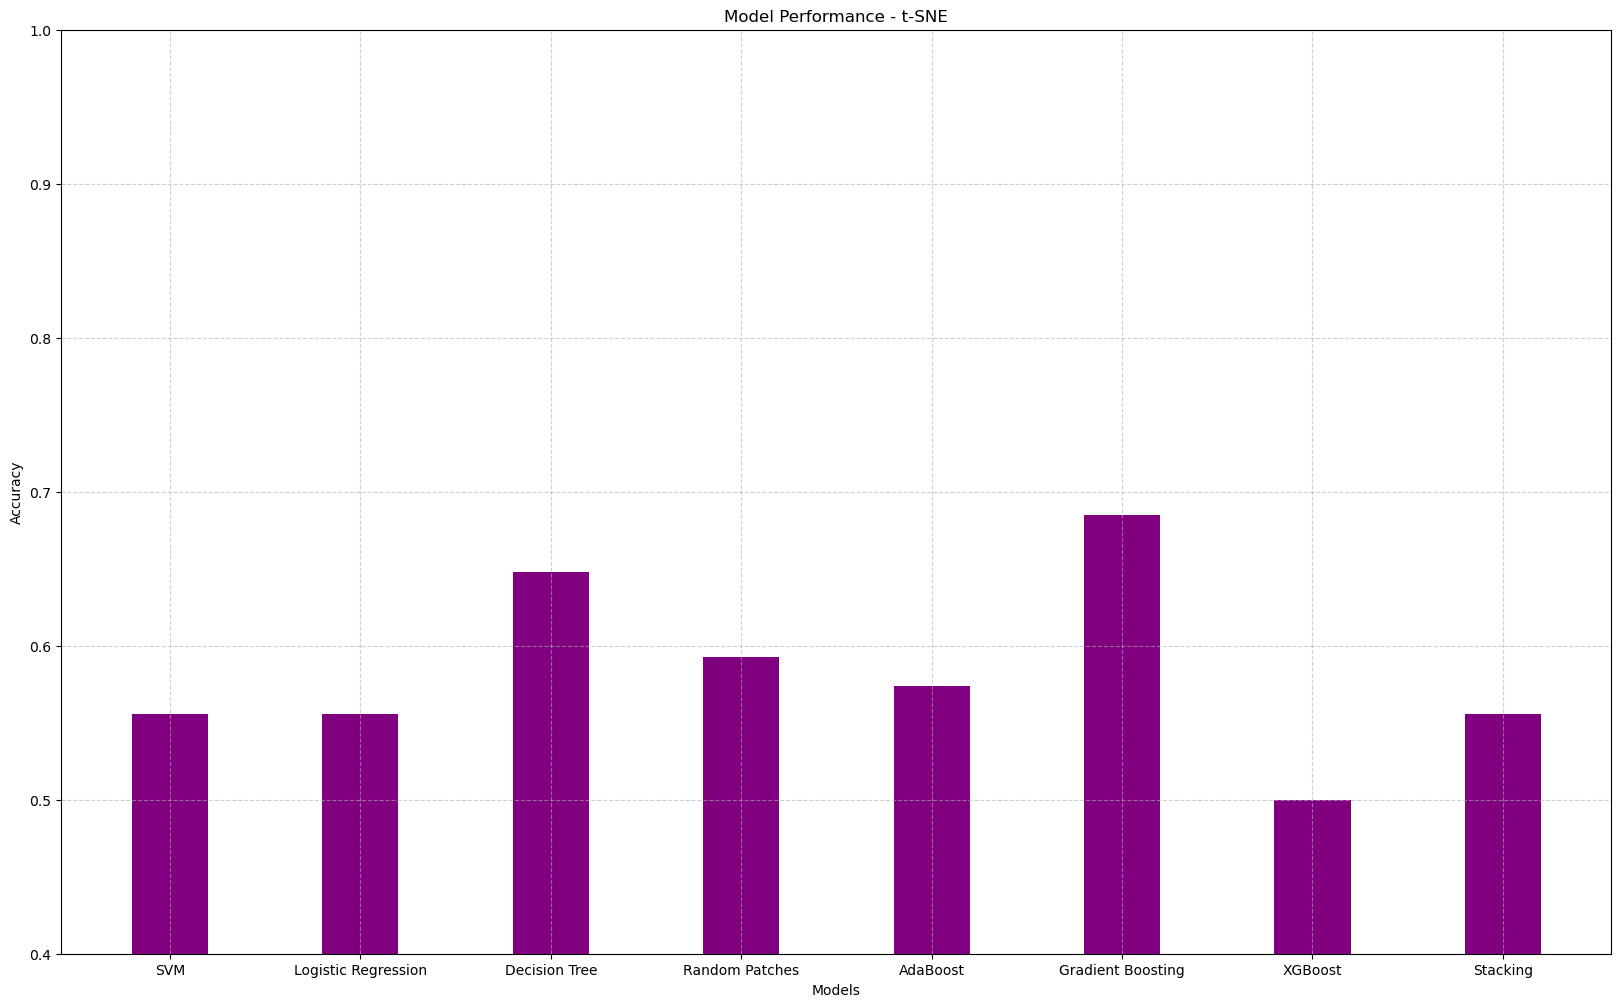

In [40]:
import matplotlib.pyplot as plt
import numpy as np



model_names = ["SVM", "Logistic Regression", "Decision Tree", "Random Patches", "AdaBoost", "Gradient Boosting", "XGBoost", "Stacking"]


def plot_model_performance(accuracies, title, color):
    plt.figure(figsize=(20, 12))
    plt.bar(model_names, accuracies, color=color, width=0.4)
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title(f'Model Performance - {title}')
    plt.ylim(0.4, 1.0)  
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


plot_model_performance(without_dimension_reduction, 'Without Dimensionality Reduction', 'blue')
plot_model_performance(pca_acc, 'PCA', 'green')
plot_model_performance(lda_acc, 'LDA', 'red')
plot_model_performance(tsne_acc, 't-SNE', 'purple')